In [5]:
import wfdb  # Assuming you have already installed wfdb
import numpy as np
import os
import tensorflow as tf  # Import TensorFlow
from tensorflow.keras.models import Sequential  # Import from tensorflow.keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
!pip install --upgrade tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 6.6 MB/s eta 0:00:00


In [3]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.4 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
path = "/content/drive/MyDrive/files"
with open(os.path.join(path, "RECORDS"), "r") as f:
    records = [line.strip() for line in f.readlines()]

print(f"Number of records: {len(records)}")

Number of records: 25


In [8]:
import os
import wfdb
import numpy as np
from tqdm import tqdm

# Lists to store segmented data and their labels
segments = []
segment_labels = []

wind_size = int(650/2)  # Given 650 is the total segment size

for filename in tqdm(records):
    if filename in ["00735", "03665", "04936", "05091"]:
        continue
    # Read the ECG signal and annotations
    sig, fields = wfdb.rdsamp(os.path.join(path, filename))
    annotations = wfdb.rdann(os.path.join(path, filename), 'atr')
    for i in range(len(annotations.aux_note)-1):
        note = annotations.aux_note[i]
        start_idx = annotations.sample[i]
        end_idx = annotations.sample[i+1]
        # Extract segment
        seg = sig[start_idx:end_idx, 0]
        if "(AFIB" == note or '(AFL' == note:
            segments.append(seg)
            segment_labels.append(1)  # AFIB label
        elif "(N" == note:
            segments.append(seg)
            segment_labels.append(0)  # Normal label

X = []
y = []

for i in tqdm(range(len(segments))):
    for j in range(0, len(segments[i]), 650):
        temp = list(segments[i][j:j+650])
        X.append(temp[:-1])  # appending only the ECG data
        y.append(segment_labels[i])  # appending the label

100%|██████████| 482/482 [00:09<00:00, 48.25it/s]


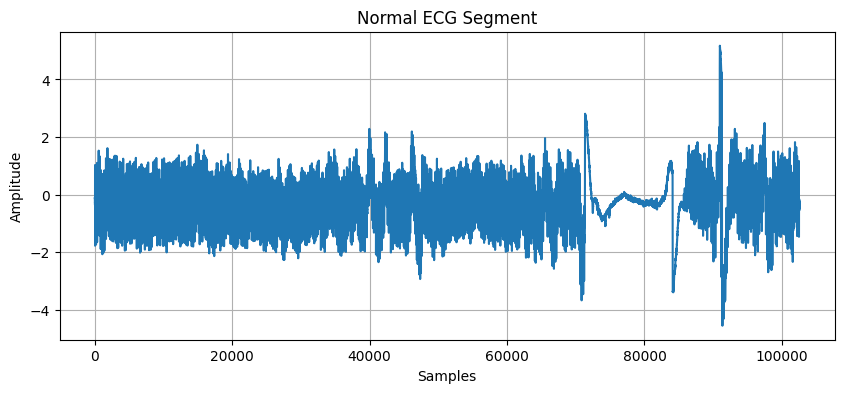

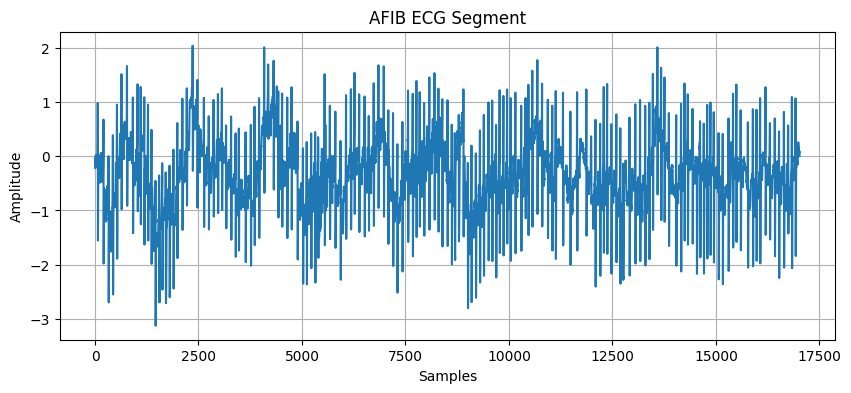

In [9]:
import matplotlib.pyplot as plt

def plot_ecg_segment(segment, title='ECG Segment'):
    plt.figure(figsize=(10, 4))
    plt.plot(segment)
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# Example usage (plotting the first normal and first AFIB segment found)
normal_indices = [i for i, label in enumerate(segment_labels) if label == 0]
afib_indices = [i for i, label in enumerate(segment_labels) if label == 1]

if normal_indices:
    plot_ecg_segment(segments[normal_indices[0]], 'Normal ECG Segment')
if afib_indices:
    plot_ecg_segment(segments[afib_indices[0]], 'AFIB ECG Segment')

In [10]:
import pandas as pd

# Combine data and labels into a dataframe
df = pd.DataFrame(X)
df['label'] = y

In [11]:
# df.to_csv('/content/drive/MyDrive/data_with_labels.csv', index=False)

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
X_normalized = [scaler.fit_transform(np.array(segment).reshape(-1, 1)) for segment in X]

# Pad the sequences to ensure they all have the same length
X_padded = pad_sequences(X_normalized, padding='post', dtype='float32')

# Now convert it to the shape suitable for 1D CNN
X_array = X_padded.reshape(X_padded.shape[0], X_padded.shape[1], 1)
y_array = np.array(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

Epoch 1/10
4498/4498 [==============================] - 28s 5ms/step - loss: 0.3626 - accuracy: 0.8377 - val_loss: 0.2429 - val_accuracy: 0.8951
Epoch 2/10
4498/4498 [==============================] - 23s 5ms/step - loss: 0.2392 - accuracy: 0.9008 - val_loss: 0.1740 - val_accuracy: 0.9299
Epoch 3/10
4498/4498 [==============================] - 23s 5ms/step - loss: 0.1891 - accuracy: 0.9235 - val_loss: 0.1714 - val_accuracy: 0.9333
Epoch 4/10
4498/4498 [==============================] - 23s 5ms/step - loss: 0.1657 - accuracy: 0.9346 - val_loss: 0.1389 - val_accuracy: 0.9476
Epoch 5/10
4498/4498 [==============================] - 23s 5ms/step - loss: 0.1503 - accuracy: 0.9416 - val_loss: 0.1335 - val_accuracy: 0.9508
Epoch 6/10
4498/4498 [==============================] - 23s 5ms/step - loss: 0.1397 - accuracy: 0.9464 - val_loss: 0.1220 - val_accuracy: 0.9562
Epoch 7/10
4498/4498 [==============================] - 23s 5ms/step - loss: 0.1304 - accuracy: 0.9502 - val_loss: 0.1189 - val_ac

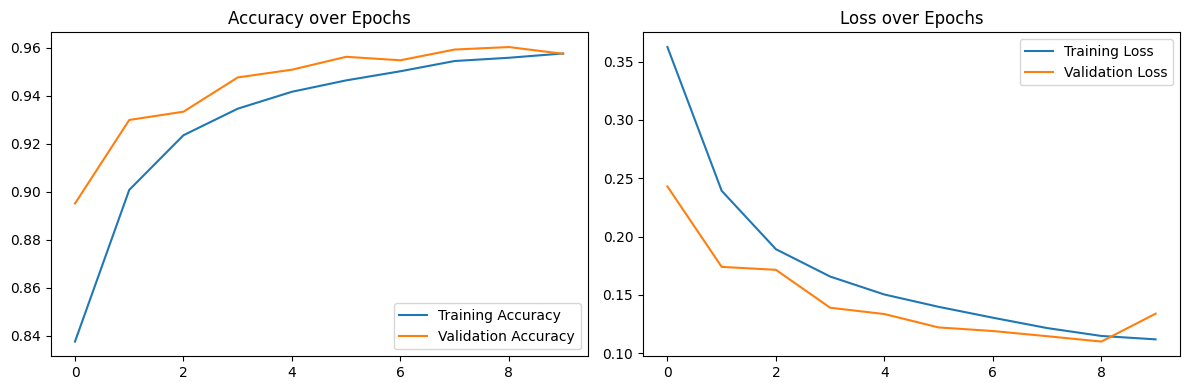

In [13]:
# 1D CNN

model = Sequential()

# First convolution layer
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(2))

# Second convolution layer
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

In [14]:
#1dcnn + LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

model = Sequential()

# 1D CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM layer
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Training the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy*100:.2f}%")
# Save the model to a file
model.save('my_model.h5')

# To confirm that the model has been saved
print("Model saved successfully.")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 647, 64)           256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 323, 64)           0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 323, 64)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 321, 128)          24704     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 160, 128)          0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 160, 128)         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


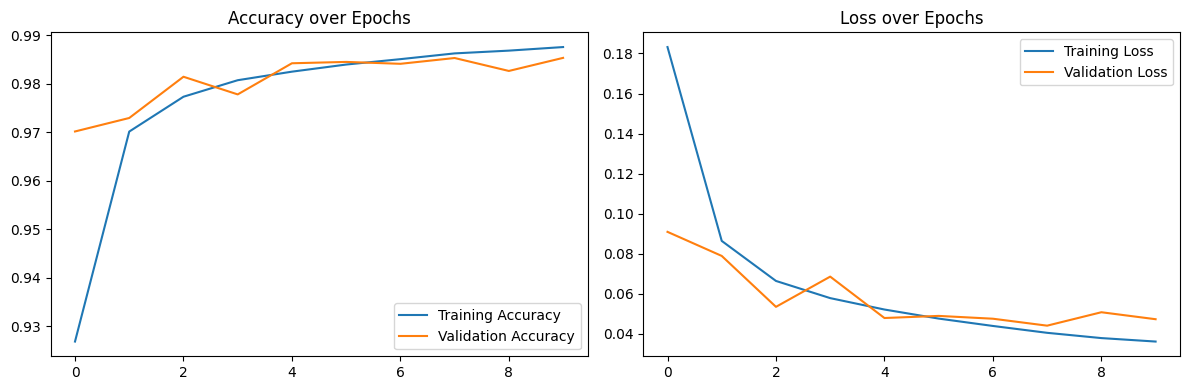

In [15]:
# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras.models import load_model
# Evaluate the model on the test data

model = load_model('/content/my_model.h5')

loss, accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Test loss: {loss:.4f}")

1125/1125 [==============================] - 5s 4ms/step - loss: 0.0472 - accuracy: 0.9854
Accuracy: 98.54%
Test loss: 0.0472


In [17]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
import os
import time
from tensorflow.keras.models import load_model

# Function to get the size of the model file
def get_model_size(model_path):
    return os.path.getsize(model_path)

# Function to time the inference process for a model
def time_inference(model, X_test):
    start_time = time.time()
    model.predict(X_test)
    end_time = time.time()
    return end_time - start_time

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load and compile the original model
model_path = '/content/my_model.h5'
model = load_model(model_path)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the original model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Original Model Accuracy: {accuracy * 100:.2f}%")
print(f"Original Model Test Loss: {loss:.4f}")

# Define pruning for only Conv1D and Dense layers
def apply_pruning_to_layers(layer):
    if isinstance(layer, tf.keras.layers.Conv1D) or isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer)
    return layer

# Rebuild the model with pruning
model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_layers,
)

model_for_pruning.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_for_pruning.summary()

# Pruning settings
batch_size = 128
epochs = 2
validation_split = 0.1

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='/tmp/log_dir'),  # Adjust as needed
]

# Train the pruned model
model_for_pruning.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=callbacks)

# Finalize the pruning
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
export_path = '/content/model_for_export.h5'
model_for_export.save(export_path)

# Load and compile the pruned model
pruned_model = load_model(export_path)
pruned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the pruned model
pruned_loss, pruned_accuracy = pruned_model.evaluate(X_test, y_test)
pruned_size = get_model_size(export_path)
pruned_inference_time = time_inference(pruned_model, X_test)

# Display results
print(f"Pruned Model Accuracy: {pruned_accuracy * 100:.2f}%")
print(f"Pruned Model Test Loss: {pruned_loss:.4f}")
print(f"Pruned Model Size: {pruned_size} bytes")
print(f"Pruned Model Inference Time: {pruned_inference_time:.2f} seconds")

Num GPUs Available:  1
1125/1125 [==============================] - 6s 4ms/step - loss: 0.0472 - accuracy: 0.9854
Original Model Accuracy: 98.54%
Original Model Test Loss: 0.0472
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv1d  (None, 647, 64)           450       
 _2 (PruneLowMagnitude)                                          
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 323, 64)           0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 323, 64)           0         
                                                                 
 prune_low_magnitude_conv1d  (None, 321, 128)          49282     
 _3 (PruneLowMagnitude)                                          
       

1012/1012 [==============================] - 28s 22ms/step - loss: 0.0331 - accuracy: 0.9884 - val_loss: 0.0236 - val_accuracy: 0.9901
Epoch 2/2
1012/1012 [==============================] - 21s 21ms/step - loss: 0.0281 - accuracy: 0.9901 - val_loss: 0.0226 - val_accuracy: 0.9910


1125/1125 [==============================] - 4s 3ms/step
Pruned Model Accuracy: 98.68%
Pruned Model Test Loss: 0.0424
Pruned Model Size: 8694824 bytes
Pruned Model Inference Time: 4.99 seconds


In [18]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os
import time
from sklearn.metrics import accuracy_score

# Load the model
model_path = "/content/my_model.h5"
model = load_model(model_path)

# Converter for dynamic range quantization
converter_dynamic = tf.lite.TFLiteConverter.from_keras_model(model)
converter_dynamic.optimizations = [tf.lite.Optimize.DEFAULT]

# Enable Select TensorFlow Operations
converter_dynamic.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,   # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS      # Enable Select TensorFlow ops.
]

# Disable experimental lower tensor list ops
converter_dynamic._experimental_lower_tensor_list_ops = False

# Convert the model
tflite_dynamic_quant_model = converter_dynamic.convert()

# Save the dynamically quantized model
dynamic_quant_model_path = '/content/dynamic_quant_model.tflite'
with open(dynamic_quant_model_path, 'wb') as f:
    f.write(tflite_dynamic_quant_model)

print(f"Dynamic Range Quantized Model Size: {os.path.getsize(dynamic_quant_model_path)} bytes")


def evaluate_tflite_model_with_time(tflite_model_path, X_test, y_test):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    predictions = []
    total_inference_time = 0

    for i in range(len(X_test)):
        input_data = X_test[i:i + 1].astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)

        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()

        total_inference_time += end_time - start_time

        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data[0][0])

    accuracy = accuracy_score(y_test, np.round(predictions))
    return accuracy, total_inference_time


dynamic_accuracy, dynamic_inference_time = evaluate_tflite_model_with_time(dynamic_quant_model_path, X_test, y_test)
print(f"Dynamic Quantized Model: Accuracy = {dynamic_accuracy * 100:.2f}%, Inference Time = {dynamic_inference_time:.2f} seconds")

Dynamic Range Quantized Model Size: 2184680 bytes
Dynamic Quantized Model: Accuracy = 98.54%, Inference Time = 239.14 seconds


In [19]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Shift the labels by one time step
y_shifted = np.roll(y, -1)

# Remove the last element of each segment since its label will now be unknown
X_shortened = [segment[:-1] for segment in X]

# Filter out empty segments from X_shortened and their corresponding labels from y_shifted
X_filtered = [segment for segment in X_shortened if len(segment) > 0]
y_filtered = np.array([y_shifted[i] for i in range(len(y_shifted)) if len(X_shortened[i]) > 0])

# Normalize data
scaler = StandardScaler()
X_normalized = [scaler.fit_transform(np.array(segment).reshape(-1, 1)) for segment in X_filtered]

# Pad the sequences
X_padded = pad_sequences(X_normalized, maxlen=650, padding='post', dtype='float32')

# Reshape for 1D CNN
X_array = X_padded.reshape(X_padded.shape[0], X_padded.shape[1], 1)
y_array = y_filtered

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

In [20]:
# LSTM + CNN
# Define your LSTM model with dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

model = Sequential()

# 1D CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM layer
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Training the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy*100:.2f}%")

# Save the model to a file
model.save('my_model_1beat_shifted.h5')

# To confirm that the model has been saved
print("Model saved successfully.")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 648, 64)           256       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 324, 64)           0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 324, 64)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 322, 128)          24704     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 161, 128)          0         
 g1D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 161, 128)         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Shift the labels by two time steps
y_shifted = np.roll(y, -2)

# Remove the last two elements of each segment since their labels will now be unknown
X_shortened = [segment[:-2] for segment in X]

# Filter out segments that have become too short
X_filtered = [segment for segment in X_shortened if len(segment) > 0]
y_filtered = np.array([y_shifted[i] for i in range(len(y_shifted)) if len(X_shortened[i]) > 0])

# Normalize data
scaler = StandardScaler()
X_normalized = [scaler.fit_transform(np.array(segment).reshape(-1, 1)) for segment in X_filtered]

# Pad the sequences
X_padded = pad_sequences(X_normalized, maxlen=650, padding='post', dtype='float32')

# Reshape for 1D CNN
X_array = X_padded.reshape(X_padded.shape[0], X_padded.shape[1], 1)
y_array = y_filtered

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

In [22]:
# LSTM + CNN
# Define your LSTM model with dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

model = Sequential()

# 1D CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM layer
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Training the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy*100:.2f}%")

# Save the model to a file
model.save('my_model_2beat_shifted.h5')

# To confirm that the model has been saved
print("Model saved successfully.")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 648, 64)           256       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 324, 64)           0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 324, 64)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 322, 128)          24704     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 161, 128)          0         
 g1D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 161, 128)         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Shift the labels by eight time steps
y_shifted = np.roll(y, -8)

# Remove the last eight elements of each segment since their labels will now be unknown
X_shortened = [segment[:-8] for segment in X]

# Filter out segments that have become too short
X_filtered = [segment for segment in X_shortened if len(segment) > 0]
y_filtered = np.array([y_shifted[i] for i in range(len(y_shifted)) if len(X_shortened[i]) > 0])

# Normalize data
scaler = StandardScaler()
X_normalized = [scaler.fit_transform(np.array(segment).reshape(-1, 1)) for segment in X_filtered]

# Pad the sequences
X_padded = pad_sequences(X_normalized, maxlen=650, padding='post', dtype='float32')

# Reshape for 1D CNN
X_array = X_padded.reshape(X_padded.shape[0], X_padded.shape[1], 1)
y_array = y_filtered

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)


In [24]:
# LSTM + CNN
# Define your LSTM model with dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

model = Sequential()

# 1D CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM layer
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Training the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy*100:.2f}%")

# Save the model to a file
model.save('my_model_8beat_shifted.h5')

# To confirm that the model has been saved
print("Model saved successfully.")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 648, 64)           256       
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 324, 64)           0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 324, 64)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 322, 128)          24704     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 161, 128)          0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 161, 128)         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
